# Dataset Exploration (Iris Dataset)

Building a decision tree classifier with maximum depth of three, using the GINI index to guide the splitting policy.

Only the third and fourth attributes of the iris dataset are used.

In [259]:
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

In [260]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [261]:
iris_table = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_table.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


This piece of code uses a library called "graphviz" that helps us (i) visualize the decision tree model we have built, and (ii) even save it as an image file, on our file directory of this notebook.

# Decision Tree Model from Scratch

In [262]:
import numpy as np

class DecisionNode:
  def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
    self.left = left
    self.right = right
    # The largest impurity value of this node
    self.impurity = impurity
    # Index of the feature which make the best fit for this node.
    self.feature_index = feature_index
    # The threshold value for that feature to make the split.
    self.threshold = threshold

class LeafNode:
  def __init__(self, value):
    self.prediction_value = value

class DecisionTreeClassifierFromScratch:
  def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
    self.root = None
    self.min_sample_split = min_sample_split
    self.min_impurity = min_impurity
    self.max_depth = max_depth
    self.impurity_function = self._calculate_information_gain
    if criterion == 'entropy':
      self.criterion = self._entropy
      self.criterion_name = criterion
    else:
      self.criterion = self._gini_index
      self.criterion_name = 'gini'

  def _gini_index(self, y):
    gini = 1
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      gini += -np.square(p)
    return gini

  def _entropy(self, y):
    entropy = 0
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      entropy += -p * np.log2(p)
    return entropy

  def _calculate_information_gain(self, y, y1, y2):
    # :param y: target value.
    # :param y1: target value for dataset in the true split/right branch.
    # :param y2: target value for dataset in the false split/left branch.

    # propobility of true values.
    p = len(y1) / len(y)
    info_gain = self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)
    return info_gain

  def _leaf_value_calculation(self, y):
    most_frequent_label = None
    max_count = 0
    unique_labels = np.unique(y)
    # iterate over all the unique values and find their frequentcy count.
    for label in unique_labels:
      count = len( y[y == label])
      if count > max_count:
        most_frequent_label = label
        max_count = count
    return most_frequent_label

  def _partition_dataset(self, Xy, feature_index, threshold):
    col = Xy[:, feature_index]
    X_1 = Xy[col >= threshold]
    X_2 = Xy[col < threshold]

    return X_1, X_2

  def _find_best_split(self, Xy):
    best_question = tuple()
    best_datasplit = {}
    largest_impurity = 0
    n_features = (Xy.shape[1] - 1)
    # iterate over all the features.
    for feature_index in range(n_features):
      # find the unique values in that feature.
      unique_value = set(s for s in Xy[:,feature_index])
      # iterate over all the unique values to find the impurity.
      for threshold in unique_value:
        # split the dataset based on the feature value.
        true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)

        # skip the node which has any on type 0. because this means it is already pure.
        if len(true_xy) > 0 and len(false_xy) > 0:
          # find the y values.
          y = Xy[:, -1]
          true_y = true_xy[:, -1]
          false_y = false_xy[:, -1]
          # calculate the impurity function.
          impurity = self.impurity_function(y, true_y, false_y)

          # if the calculated impurity is larger than save this value for comaparison (highest gain).
          if impurity > largest_impurity:
            largest_impurity = impurity
            best_question = (feature_index, threshold)
            best_datasplit = {
              "leftX": true_xy[:, :n_features],   # X of left subtree
              "lefty": true_xy[:, n_features:],   # y of left subtree
              "rightX": false_xy[:, :n_features],  # X of right subtree
              "righty": false_xy[:, n_features:]   # y of right subtree
            }

    return largest_impurity, best_question, best_datasplit

  def _build_tree(self, X, y, current_depth=0):
    n_samples , n_features = X.shape
    # Add y as last column of X
    Xy = np.column_stack((X, y))
    # find the Information gain on each feature each values and return the question which splits the data very well
    if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
      # find the best split/ which question split the data well.
      impurity, quesion, best_datasplit = self._find_best_split(Xy)
      if impurity > self.min_impurity:
        # Build subtrees for the right and left branch.
        true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
        false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
        return DecisionNode(impurity=impurity, feature_index=quesion[0], threshold=quesion[1],
                            left=true_branch, right=false_branch)

    leaf_value = self._leaf_value_calculation(y)
    return LeafNode(value=leaf_value)

  def fit(self, X, y):
    self.root = self._build_tree(X, y, current_depth=0)

  def predict_sample(self, x, tree=None):
    if isinstance(tree , LeafNode):
      return tree.prediction_value

    if tree is None:
      tree = self.root
    feature_value = x[tree.feature_index]
    branch = tree.right

    if isinstance(feature_value, int) or isinstance(feature_value, float):
      if feature_value >= tree.threshold:
        branch = tree.left
    elif feature_value == tree.threshold:
      branch = tree.left

    return self.predict_sample(x, branch)

  def predict(self, test_X):
    x = np.array(test_X)
    y_pred = [self.predict_sample(sample) for sample in x]
    y_pred = np.array(y_pred)
    return y_pred

  def draw_tree(self):
    self._draw_tree(self.root)

  def _draw_tree(self, tree = None, indentation = " ", depth=0):
    if isinstance(tree , LeafNode):
      print(indentation,"The predicted value -->", tree.prediction_value)
      return
    else:
      print(indentation,f"({depth}) Is {tree.feature_index}>={tree.threshold}?"
            f": {self.criterion_name}:{tree.impurity:.2f}")
      if tree.left is not None:
          print (indentation + '----- True branch :)')
          self._draw_tree(tree.left, indentation + "  ", depth+1)
      if tree.right is not None:
          print (indentation + '----- False branch :)')
          self._draw_tree(tree.right, indentation + "  ", depth+1)

In [263]:
tree = DecisionTreeClassifierFromScratch(max_depth=3)
# tree = DecisionTreeClassifier(max_depth=3, criterion="gini")
tree.fit(X, y)

In [264]:
tree.predict([[2.5,1.7]])

array([0.])

In [265]:
from sklearn.metrics import accuracy_score
y_t_pred = tree.predict(X)
accuracy_score(y, y_t_pred)

0.9733333333333334

# Decision Tree Model from Sci-Kit Learn

In [266]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=3)
# tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")
tree.fit(X, y)

DecisionTreeClassifier(max_depth=3)

Visualize model by graphviz

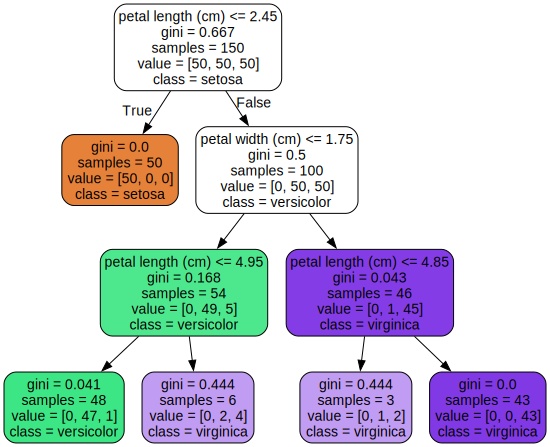

In [267]:
from sklearn.tree import export_graphviz
from graphviz import Source

import os
PROJECT_ROOT_DIR = r"C:\Users\user\git\Machine-Learning-Lab-KMITL\week_4_homework"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree_images")
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
    tree, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "iris_tree_01.dot"),
    feature_names = iris.feature_names[2:],
    class_names = iris.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "iris_tree_01.dot"))

A simple prediction of just one flower instance.

In [268]:
tree.predict([[2.5,1.7]])

array([1])

In [269]:
y_t_pred = tree.predict(X)
accuracy_score(y, y_t_pred)

0.9733333333333334

# Dataset Exploration (Breast Cancer Dataset)

In [270]:
from sklearn.datasets import load_breast_cancer

In [271]:
cancer = load_breast_cancer()
cancer

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [272]:
cancer_table = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_table.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [273]:
X = cancer.data[:, (0,1)] #Calculated by mean of radius & texture of cancer point
y = cancer.target #To distinguish malignant (ก้อนเนื้อร้าย/Bad tumor/cancer/1) or benign (ก้อนเนื้องอกที่ไม่อันตราย/Non-cancer/0)

In [274]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Comparison between Criterion = 'entropy' vs Criterion = 'gini' (GINI index)

In [275]:
tree = DecisionTreeClassifier(max_depth=2, criterion="entropy")
tree_gini = DecisionTreeClassifier(max_depth=2, criterion="gini")
tree.fit(X_train,y_train)
tree_gini.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [276]:
#project directory path
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "cancer images")
os.makedirs(IMAGES_PATH, exist_ok=True)

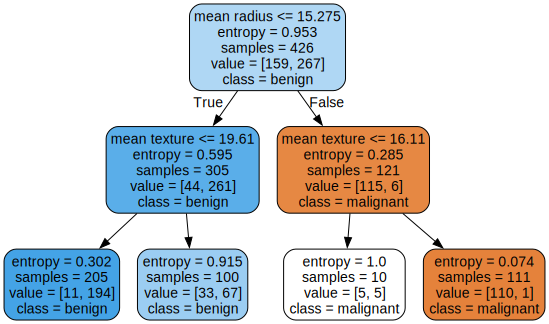

In [277]:
#Tree model
export_graphviz(
    tree, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_01.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_01.dot"))

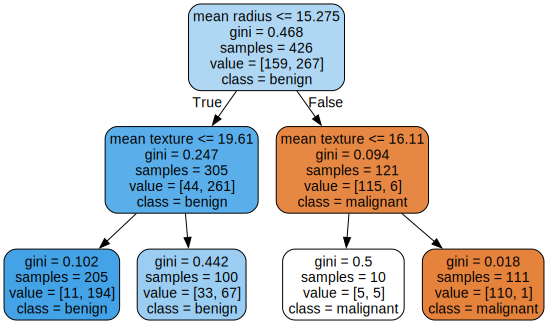

In [278]:
#Tree model with gini
export_graphviz(
    tree_gini, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_gini_01.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_gini_01.dot"))

In [279]:
#Tree model-based prediction w/ Entropy criterion
tree.predict([[11.42, 20.38]])

array([1])

In [280]:
y_t_pred = tree.predict(X_test)
accuracy_score(y_test, y_t_pred)

0.8881118881118881

In [281]:
#Tree model w/ gini criterion-based prediction
tree_gini.predict([[11.42, 20.38]])

array([1])

In [282]:
y_tg_pred = tree_gini.predict(X_test)
accuracy_score(y_test, y_tg_pred)

0.8881118881118881

If define deeper decision tree model

In [283]:
tree_d6 = DecisionTreeClassifier(max_depth=6, criterion="entropy")
tree_gini_d6 = DecisionTreeClassifier(max_depth=6, criterion="gini")
tree_d6.fit(X,y)
tree_gini_d6.fit(X,y)

DecisionTreeClassifier(max_depth=6)

In [284]:
y_t_pred = tree_d6.predict(X)
accuracy_score(y, y_t_pred)

0.9367311072056239

In [285]:
y_tg_pred = tree_gini_d6.predict(X)
accuracy_score(y, y_tg_pred)

0.9437609841827768

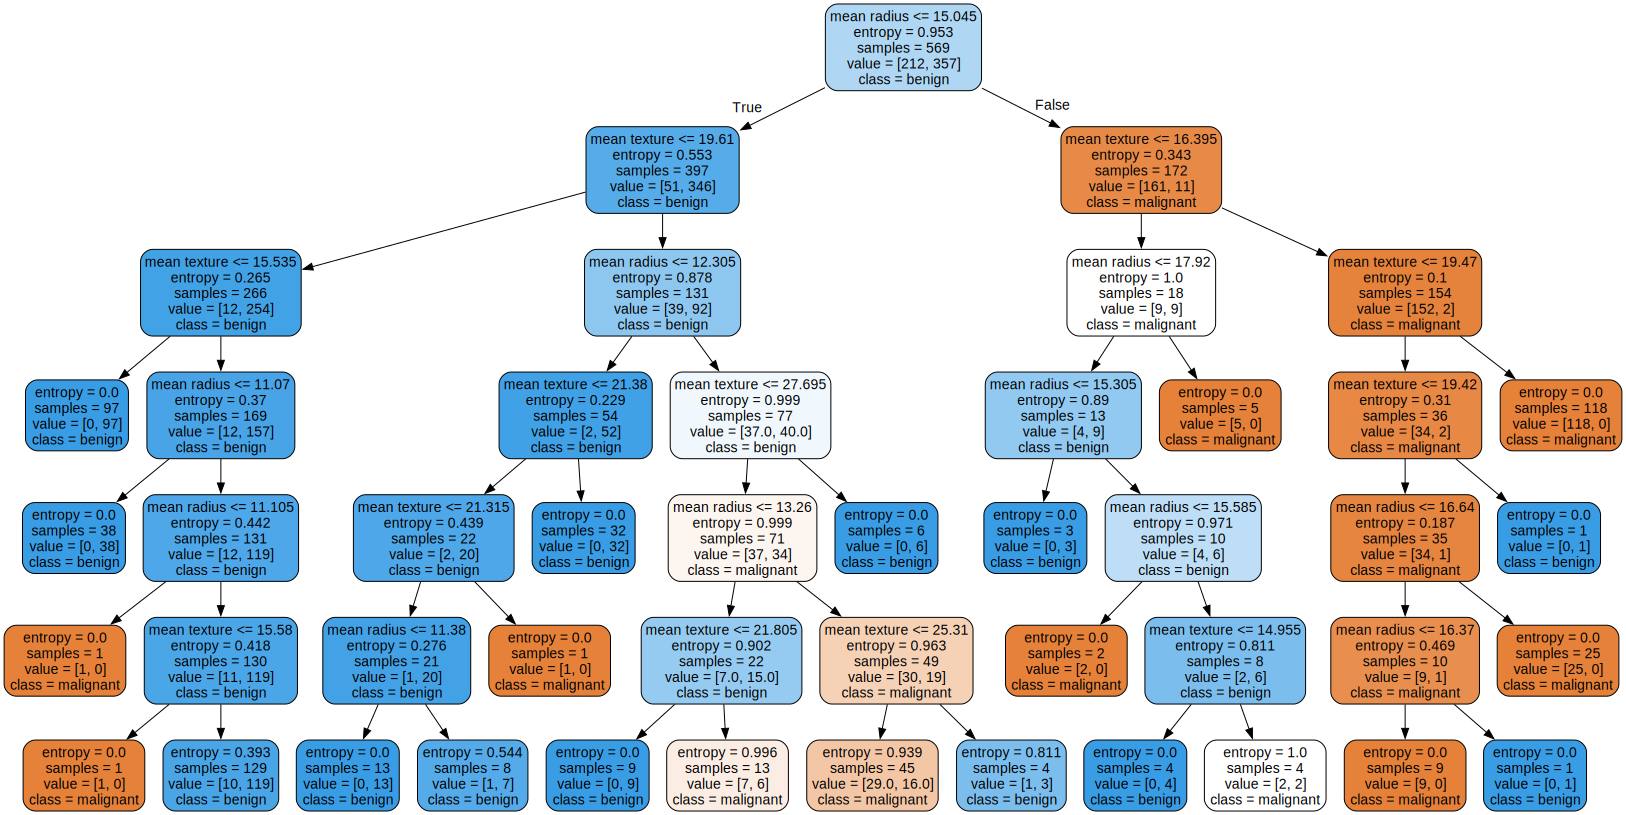

In [286]:
#Tree model
export_graphviz(
    tree_d6, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_deep6.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_deep6.dot"))

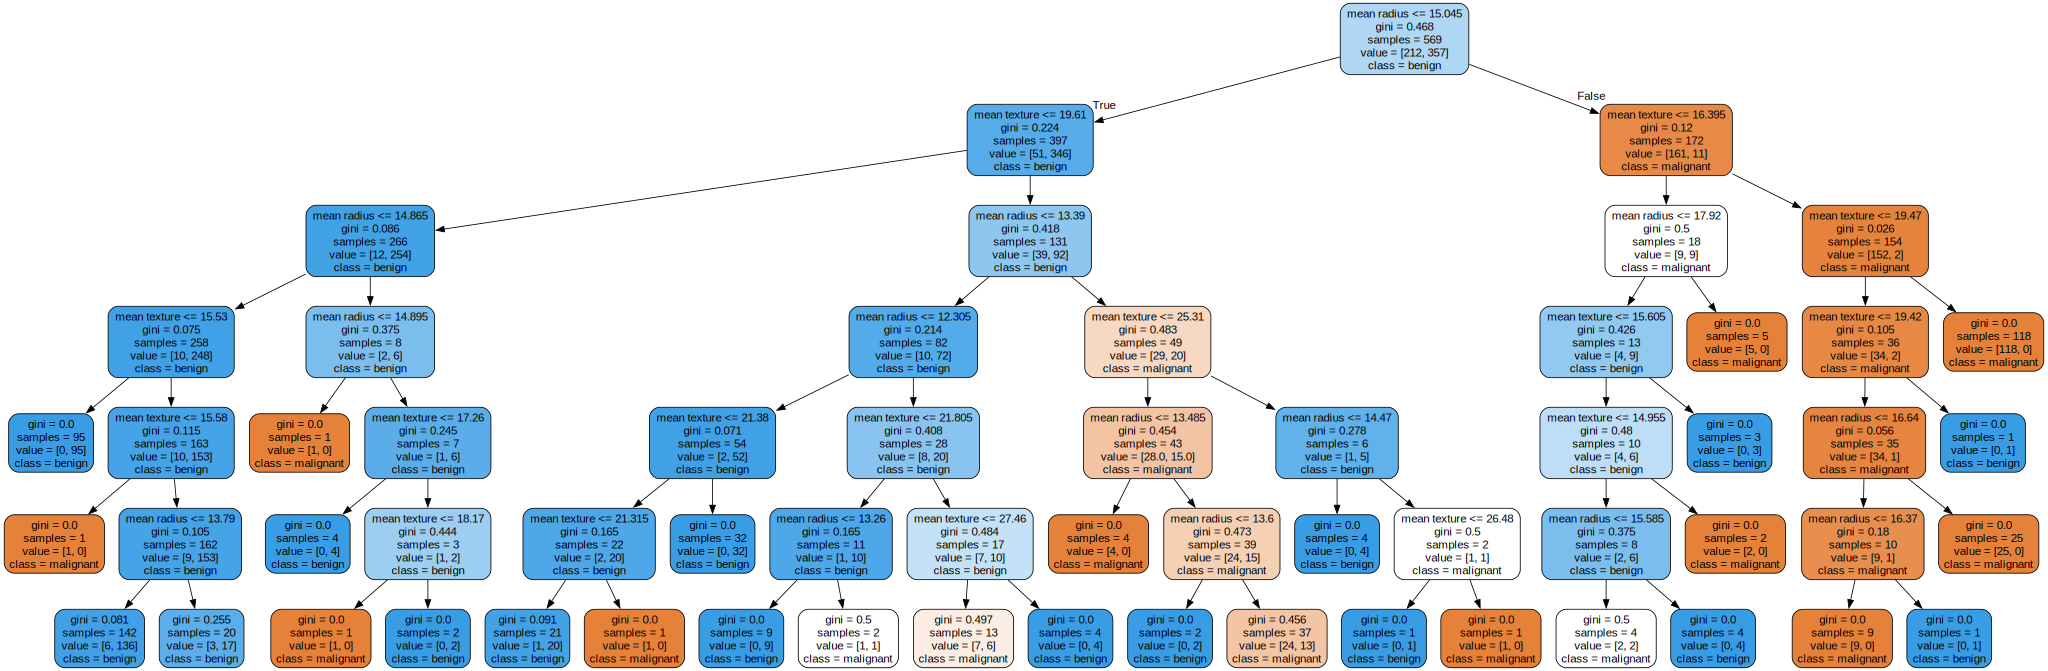

In [287]:
#Tree model
export_graphviz(
    tree_gini_d6, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_gini_deep6.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_gini_deep6.dot"))

More & More deeper (d=10)

In [288]:
tree_d10 = DecisionTreeClassifier(max_depth=10, criterion="entropy")
tree_gini_d10 = DecisionTreeClassifier(max_depth=10, criterion="gini")
tree_d10.fit(X,y)
tree_gini_d10.fit(X,y)

y_t_pred = tree_d10.predict(X)
acc_d10 = accuracy_score(y, y_t_pred)

y_tg_pred = tree_gini_d10.predict(X)
acc_gd10 = accuracy_score(y, y_tg_pred)

print(acc_d10, acc_gd10)

0.9630931458699473 0.984182776801406


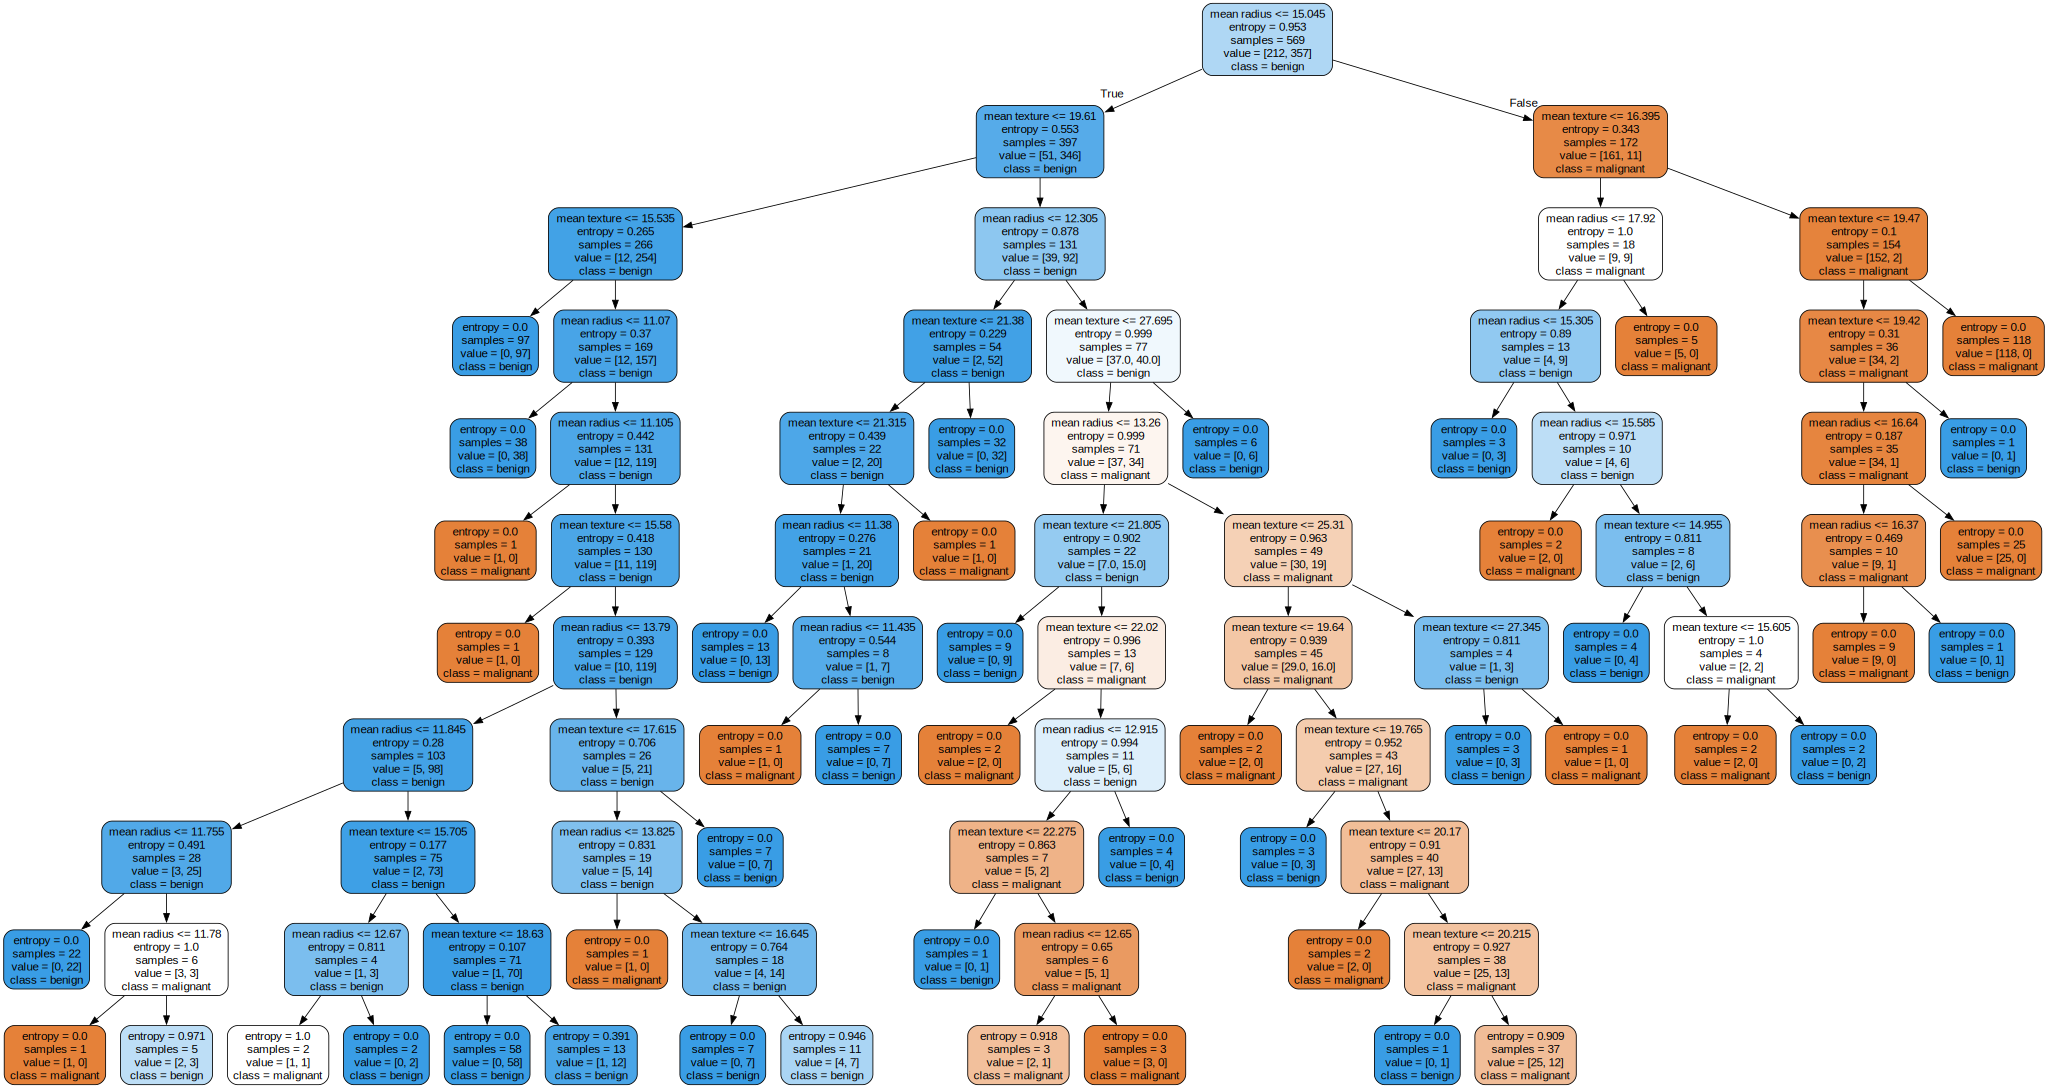

In [289]:
#Tree model
export_graphviz(
    tree_d10, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_deep10.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_deep10.dot"))

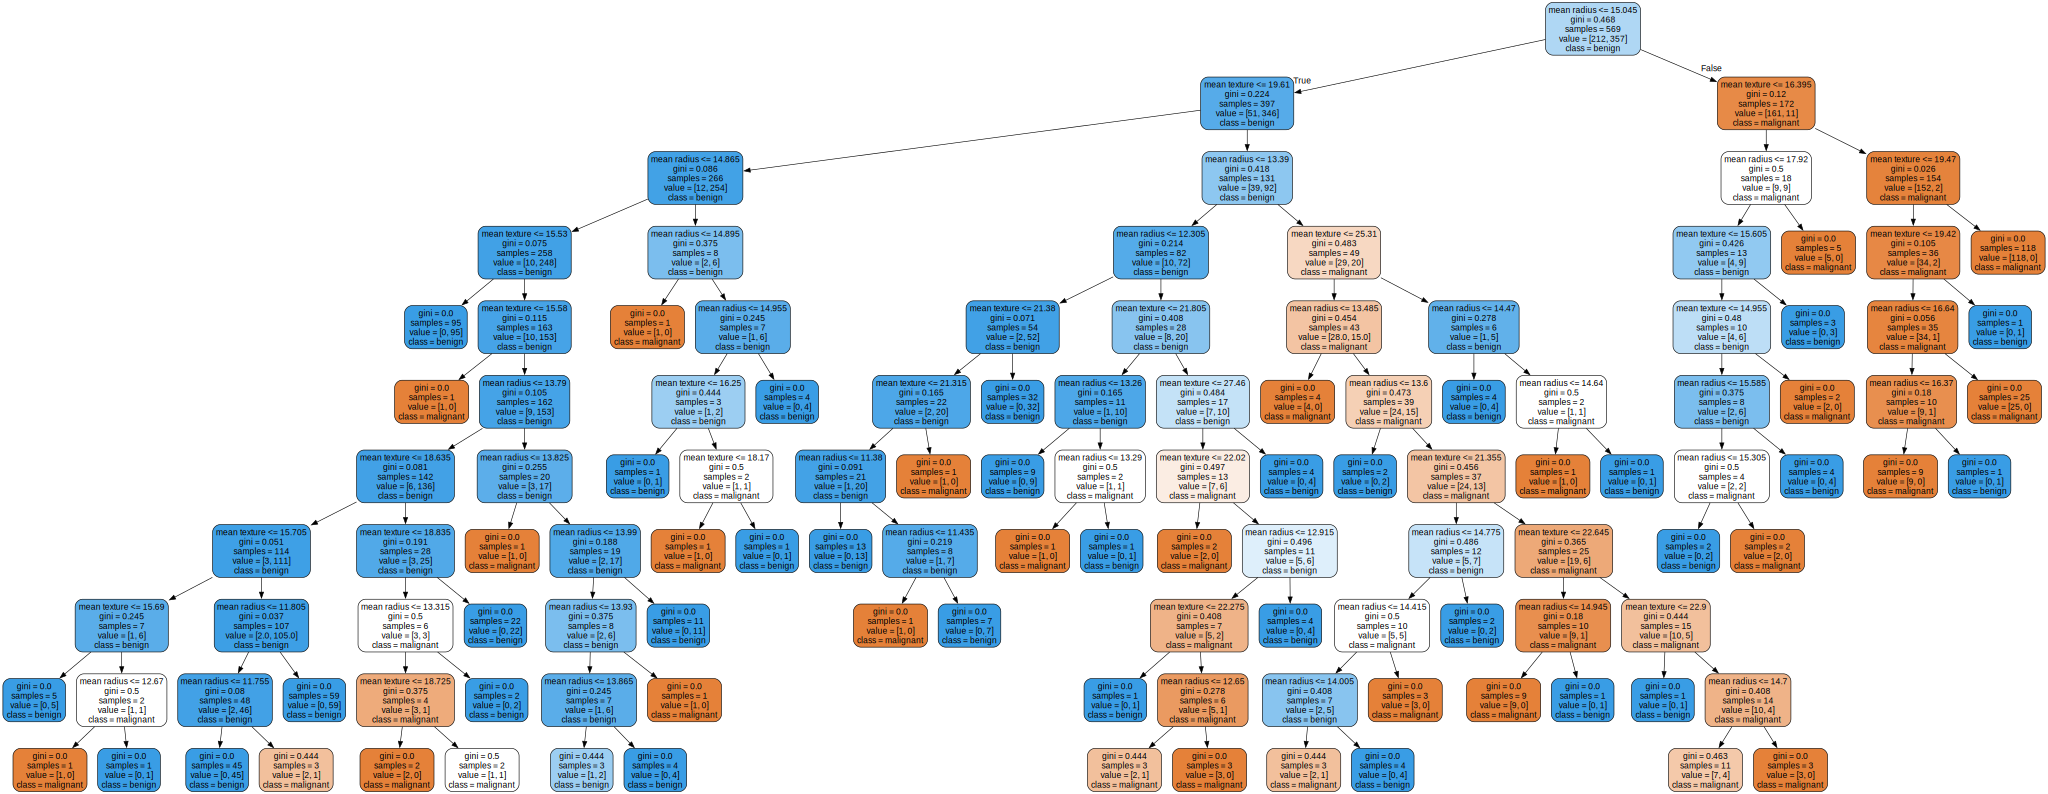

In [290]:
#Tree model
export_graphviz(
    tree_gini_d10, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "cancer_tree_gini_deep10.dot"),
    feature_names = cancer.feature_names[0:2],
    class_names = cancer.target_names,
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "cancer_tree_gini_deep10.dot"))

# Homework

จาก Dataset ที่ถูกสร้างขึ้นมาจงทดลองสร้าง Decision Tree Model ที่มี Max Depth อยู่ในช่วง [1, 20] เเละหาว่า Depth ขนาดไหนที่มีค่า Accuracy เฉลี่ยจาก Seed 0 - 200 (ที่ใช้ตอน train_test_split(dataset.data, dataset.target, test_size=0.25, random_state=**seed**)) เเล้วจึงแสดงผลภาพโมเดลผ่าน graphwiz เเล้วนำมาใส่ใน PDF


``` python

'''
    Arg:
        X = cancer.data[:, :5] #Calculated by mean of radius & texture of cancer point
        y = cancer.target #To distinguish malignant (ก้อนเนื้อร้าย/Bad tumor/cancer/1) or benign (ก้อนเนื้องอกที่ไม่อันตราย/Non-cancer/0)
'''

num_features = 10
num_classes = 3

X, y = make_classification(
    n_samples=1000,        # Total number of samples
    n_features=num_features,         # Number of features
    n_informative=5,       # Number of informative features
    n_redundant=2,         # Number of redundant features
    n_clusters_per_class=2,# Clusters per class
    weights=[0.7, 0.2, 0.1], # Class imbalance for 3 classes
    flip_y=0.1,            # Introduce label noise
    n_classes=num_classes,           # Number of classes
    random_state=42
)
experiment_dataset = CustomDataset(X,
                                   y,
                                   [chr(i + ord('A')) for i in range(num_features)],
                                   [str(i) for i in range(num_classes)])


def compareAvgAccuracy(dataset, seed_range, depth_range):
    acc = 0.0
    saved = None
    best_depth = None

    for i in range(depth_range[0], depth_range[1]):
        total_seed_acc = 0.0
        for seed in range(seed_range[0], seed_range[1]):
            X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.25, random_state=seed)
        #  สร้าง Training & Testing Segment ขึ้นมาเอง
        #
        #
        #
        #

        avg_seed_acc = total_seed_acc / (seed_range[1] - seed_range[0])
        print(f"Depth {i}, Avg Acc : {avg_seed_acc}")

        if avg_seed_acc > acc:
            acc = avg_seed_acc
            saved = # tree
            best_depth = i


    filename = f"tree_maxacc_{best_depth}.dot"
    dot_file_path = os.path.join(IMAGES_PATH, filename)
    png_file_path = dot_file_path.replace('.dot', '')

    # Export
    export_graphviz(
        # ระบุ Parameter ที่ใช้ในการ Export
        #
        #
        #
        #
        #
    )

    source = Source.from_file(dot_file_path)
    source.render(png_file_path, format='png', cleanup=True)

    img = plt.imread(png_file_path+".png")
    plt.imshow(img)
    plt.title(f"Tree at best depth {best_depth}")
    plt.axis('off')
    plt.show()

# Example usage
compareAvgAccuracy(experiment_dataset, (0, 200), (1, 21))
```

cur_depth ->  1
Depth 1, Avg Acc : 0.7290799999999998
cur_depth ->  2
Depth 2, Avg Acc : 0.7533399999999999
cur_depth ->  3
Depth 3, Avg Acc : 0.7798600000000003
cur_depth ->  4
Depth 4, Avg Acc : 0.7895400000000007
cur_depth ->  5
Depth 5, Avg Acc : 0.7902200000000001
cur_depth ->  6
Depth 6, Avg Acc : 0.7911400000000005
cur_depth ->  7
Depth 7, Avg Acc : 0.7868000000000008
cur_depth ->  8
Depth 8, Avg Acc : 0.7812400000000003
cur_depth ->  9
Depth 9, Avg Acc : 0.7740200000000006
cur_depth ->  10
Depth 10, Avg Acc : 0.7661000000000006
cur_depth ->  11
Depth 11, Avg Acc : 0.7623399999999999
cur_depth ->  12
Depth 12, Avg Acc : 0.7577200000000001
cur_depth ->  13
Depth 13, Avg Acc : 0.7531800000000003
cur_depth ->  14
Depth 14, Avg Acc : 0.7508799999999998
cur_depth ->  15
Depth 15, Avg Acc : 0.74566
cur_depth ->  16
Depth 16, Avg Acc : 0.7461799999999996
cur_depth ->  17
Depth 17, Avg Acc : 0.7445999999999999
cur_depth ->  18
Depth 18, Avg Acc : 0.7422400000000003
cur_depth ->  19
Dept

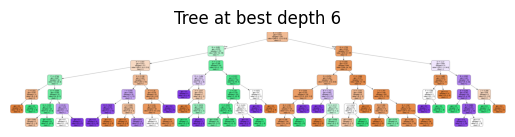

In [291]:
from sklearn.datasets import make_classification
from sklearn.utils import Bunch

def CustomDataset(data, target, feature_names, target_names) -> Bunch:
    dataset = Bunch(data=data,
                    target=target,
                    feature_names=feature_names,
                    target_names=target_names
                )
    return dataset

num_features = 10
num_classes = 3

X, y = make_classification(
    n_samples=1000,        # Total number of samples
    n_features=num_features,         # Number of features
    n_informative=5,       # Number of informative features
    n_redundant=2,         # Number of redundant features
    n_clusters_per_class=2,# Clusters per class
    weights=[0.7, 0.2, 0.1], # Class imbalance for 3 classes
    flip_y=0.1,            # Introduce label noise
    n_classes=num_classes,           # Number of classes
    random_state=42
)
experiment_dataset = CustomDataset(X, 
                                   y, 
                                   [chr(i + ord('A')) for i in range(num_features)], 
                                   [str(i) for i in range(num_classes)])


def compareAvgAccuracy(dataset, seed_range, depth_range):
    acc = 0.0
    saved = None
    best_depth = None

    for i in range(depth_range[0], depth_range[1]):
        print("cur_depth -> ", i)
        total_seed_acc = 0.0
        model = DecisionTreeClassifier(max_depth=i)
        for seed in range(seed_range[0], seed_range[1]):
            X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.25, random_state=seed)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            total_seed_acc += accuracy_score(y_test, y_pred)

        avg_seed_acc = total_seed_acc / (seed_range[1] - seed_range[0])
        print(f"Depth {i}, Avg Acc : {avg_seed_acc}")
        
        if avg_seed_acc > acc:
            acc = avg_seed_acc
            saved = model # tree
            best_depth = i

    IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "hw_result")
    os.makedirs(IMAGES_PATH, exist_ok=True)
    filename = f"tree_maxacc_{best_depth}.dot"
    dot_file_path = os.path.join(IMAGES_PATH, filename)
    png_file_path = dot_file_path.replace('.dot', '')

    # Export
    export_graphviz(
        # ระบุ Parameter ที่ใช้ในการ Export
        saved,
        out_file = os.path.join(IMAGES_PATH, filename),
        feature_names = dataset.feature_names,
        class_names = dataset.target_names,
        rounded = True,
        filled = True
    )

    source = Source.from_file(dot_file_path)
    source.render(png_file_path, format='png', cleanup=True)

    img = plt.imread(png_file_path+".png")
    plt.imshow(img)
    plt.title(f"Tree at best depth {best_depth}")
    plt.axis('off')
    plt.show()

# Example usage
compareAvgAccuracy(experiment_dataset, (0, 200), (1, 21))

In [292]:
experiment_dataset

{'data': array([[-3.9673855 , -1.5480325 , -1.72168257, ...,  1.39791098,
          1.06028864, -1.62789785],
        [-2.24352875, -0.94321635, -0.06937837, ...,  3.00642262,
          1.07252071,  1.08978701],
        [-1.09228286, -1.07677738, -2.1737689 , ...,  1.28872916,
          1.91272685,  0.69537724],
        ...,
        [-2.8853104 , -2.152923  ,  0.58863546, ...,  1.4902466 ,
          0.15334477, -0.71449609],
        [ 2.09801929,  0.46105321, -0.42026861, ...,  2.32958036,
          0.67203495, -0.25207597],
        [-3.38697429, -2.53115813,  0.37227461, ...,  1.90500437,
          1.1681684 , -0.90761353]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0,
        0, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0,
        0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0,
        1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 